In [3]:
import sys
sys.path.append("/home/jaxmao/jaxmaov2_/JaxMao/")

In [5]:
%load_ext autoreload
%autoreload 2

from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from jaxmao.modules import Module, Dense, Bind
from jaxmao import losses, optimizers
import jax
from jaxmao import regularizers 
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def get_dataloader(batch_size, shuffle):
    class DigitsDataset(Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
            
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            return self.data[idx], self.labels[idx]
        
    digits = load_digits()
    data = digits.data
    targets = digits.target
    
    dataset = DigitsDataset(data, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

class Autoencoder(Module):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(64, 128)
        self.dense2 = Dense(128, 64)
        self.dense3 = Dense(64, 128)

        self.dense4 = Dense(128, 64)
        self.dense5 = Dense(64, 128)
        self.dense6 = Dense(128, 64)
        
    def call(self, x):
        return self.decoder(self.encoder(x))
    
    def encoder(self, x):
        x = jax.nn.relu(self.dense1(x))
        x = jax.nn.relu(self.dense2(x))
        x = jax.nn.relu(self.dense3(x))
        return x
        
    def decoder(self, x):
        x = jax.nn.relu(self.dense4(x))
        x = jax.nn.relu(self.dense5(x))
        x = self.dense6(x)
        return x

In [41]:
seed = 42
key = jax.random.key(seed=seed)
datalodaer = get_dataloader(batch_size=32, shuffle=True)
model = Autoencoder()
params, states = model.init(key)
optimizer = optimizers.Adam(params=params, lr=0.01)
loss_fn = losses.MeanSquaredError()

In [42]:
@jax.jit
def train_step(images, targets, params, states, optimizer_states):
    def loss(images, params, states):
        predictions, states, reg = model.apply(images, params, states)
        return loss_fn(predictions, targets) + reg, states

    (loss_value, states), gradients = jax.value_and_grad(loss, argnums=1, has_aux=True)(images, params, states)
    params, optimizer_states = optimizer.step(params, gradients, optimizer_states)
    return loss_value, params, states, optimizer_states

for epoch in range(200):
    losses_value = 0
    for i, (images, _) in enumerate(datalodaer):
        images = jax.device_put(images.numpy())
        loss_value, params, states, optimizer.states = train_step(images, images, params, states, optimizer.states)
        losses_value += loss_value
    print('losses_avg: ', losses_value / len(datalodaer))

losses_avg:  1147.5103
losses_avg:  549.6023
losses_avg:  440.51428
losses_avg:  363.55814
losses_avg:  323.19113
losses_avg:  297.2819
losses_avg:  272.1803
losses_avg:  261.59744
losses_avg:  254.58336
losses_avg:  235.6109
losses_avg:  252.27756
losses_avg:  226.02371
losses_avg:  222.79561
losses_avg:  226.0478
losses_avg:  210.15176
losses_avg:  210.44041
losses_avg:  208.03041
losses_avg:  203.85353
losses_avg:  198.53407
losses_avg:  191.2038
losses_avg:  194.71513
losses_avg:  193.79196
losses_avg:  191.34502
losses_avg:  197.06487
losses_avg:  185.22836
losses_avg:  191.27744
losses_avg:  180.96404
losses_avg:  179.56
losses_avg:  184.8329
losses_avg:  186.55457
losses_avg:  176.82007
losses_avg:  181.97699
losses_avg:  175.30806
losses_avg:  172.54494
losses_avg:  176.7061
losses_avg:  175.25887
losses_avg:  171.73982
losses_avg:  173.03603
losses_avg:  181.12192
losses_avg:  163.74716
losses_avg:  170.36252
losses_avg:  174.5011
losses_avg:  164.64937
losses_avg:  171.6363
l

In [43]:
with Bind(model, params, states) as ctx:
    for i, (images, batch_targets) in enumerate(datalodaer): 
        images = jax.device_put(images.numpy())
        batch_predictions = ctx.module(images)

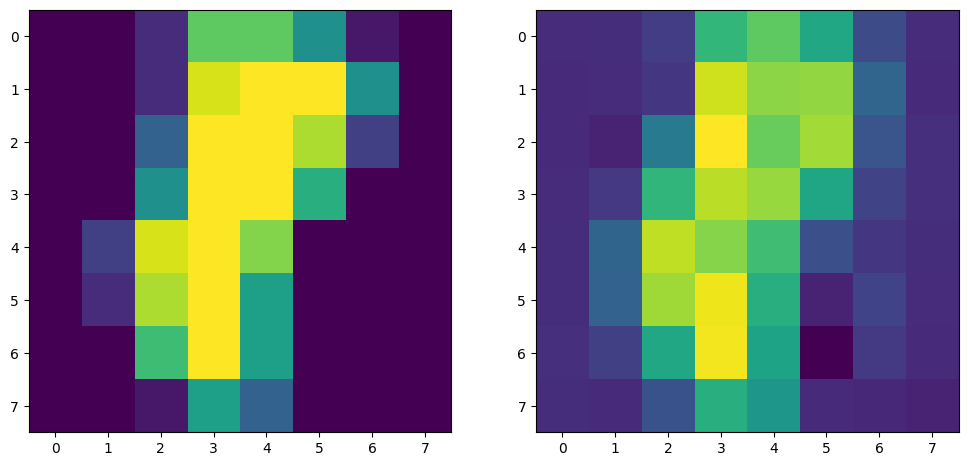

In [57]:
import matplotlib.pyplot as plt
idx = 5
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(images[idx].reshape(8, 8))
plt.subplot(1, 2, 2)
plt.imshow(batch_predictions[idx].reshape(8, 8))
plt.show()

# Plot tsne

some color settings

In [71]:
import matplotlib.colors as mcolors

def color_map(value):
    max_value = 10 # max_value here is number of classes.
    hue = value / max_value
    rgb = mcolors.hsv_to_rgb([hue, 1, 1])
    return rgb

def color_map_array(values):
    return [color_map(value) for value in values]

let start here

In [75]:
training_set = load_digits()
training_images, training_labels = training_set.data, training_set.target

with Bind(model, params, states) as ctx:
    images = jax.device_put(training_images)
    training_features = ctx.module.encoder(images)

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
training_features_2d = tsne.fit_transform(training_features)

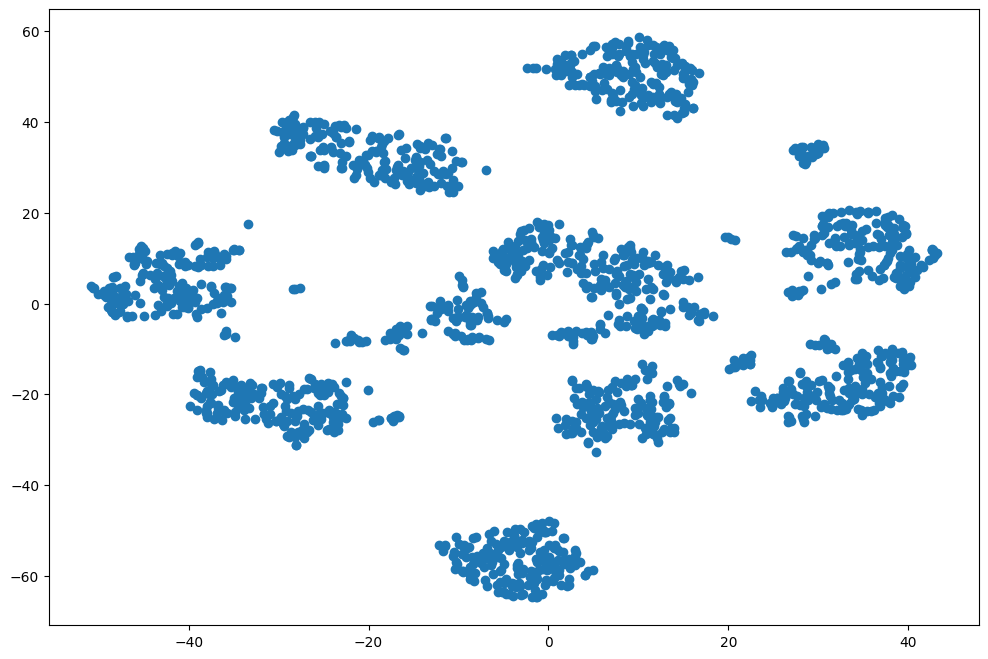

In [79]:
plt.figure(figsize=(12, 8))
plt.scatter(training_features_2d[..., 0], training_features_2d[..., 1])
plt.show()

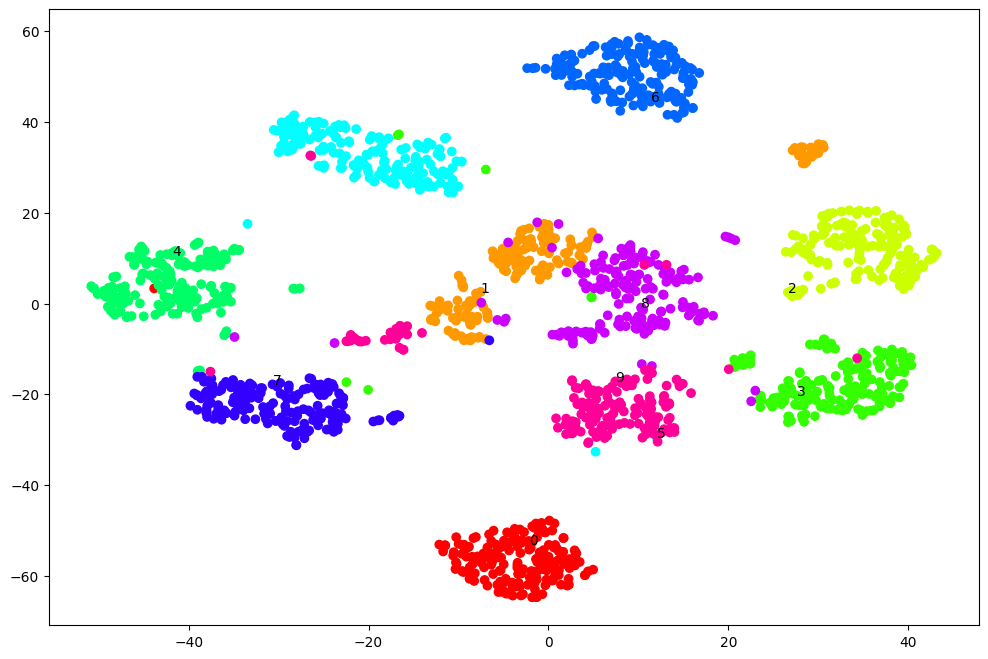

In [78]:
import numpy as np

unique_labels = np.unique(training_labels)
taken = []
plt.figure(figsize=(12, 8))
for label in unique_labels:
    idx = np.where(training_labels == label)
    plt.scatter(training_features_2d[idx, 0], training_features_2d[idx, 1], label=label, c=color_map_array(training_labels[idx]))
    if len(idx[0]) > 0:
        i = idx[0][0]
        if i not in taken:
            plt.annotate(str(label), (training_features_2d[i, 0], training_features_2d[i, 1]))
            taken.append(i)